<a href="https://colab.research.google.com/github/IdoZada/Course-Computer-Vison/blob/master/HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import math
from skimage.transform import rotate, AffineTransform, warp
from matplotlib import pyplot as plt
import keras
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def show_all(image_list,title_list):
    plt.figure(figsize=[20,10])
    assert len(image_list) == len(title_list)
    N = len(image_list)
    for index,(img,title) in enumerate(zip(image_list,title_list)):
      plt.subplot(1,N,index+1)
      if len(img.shape) != 3:
        plt.imshow(img,cmap='gray')
      else:
        plt.imshow(img)
      plt.title(title)
    plt.show()
    

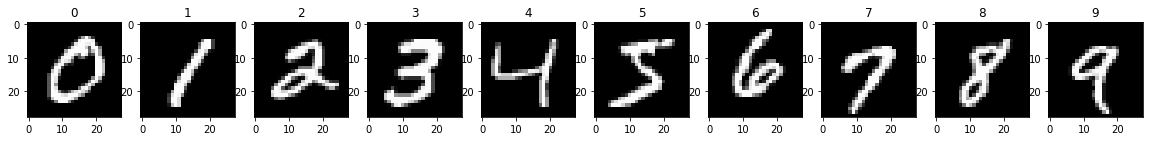

In [11]:
img_list , indices = np.unique(y_train,return_index=True)
image_list = list()
for index in indices:
  image_list.append(x_train[index])
show_all(image_list,img_list)


def splitDataset(x_train,y_train):
  x_train_zero = x_train[y_train == 0]
  x_train_one = x_train[y_train == 1]
  x_train_two = x_train[y_train == 2]
  x_train_three = x_train[y_train == 3]
  x_train_four = x_train[y_train == 4]
  x_train_five = x_train[y_train == 5]
  x_train_six = x_train[y_train == 6]
  x_train_seven = x_train[y_train == 7]
  x_train_eight = x_train[y_train == 8]
  x_train_nine = x_train[y_train == 9]
  return {'0': x_train_zero , '1' : x_train_one,'2' : x_train_two,'3' : x_train_three,'4' : x_train_four ,'5': x_train_five,'6': x_train_six,'7' : x_train_seven,'8' : x_train_eight,'9': x_train_nine}
  
folders_dict = splitDataset(x_train,y_train)


In [0]:
# Creates a data set of numbers between 0 - 100 
def createRepository(folders_dict):
    dataset = dict()
    x_train = list()
    y_train = list()
    for i in range(101):
      if len(str(i)) == 1:
        for j in range(6000):
          new_list = []
          new_list.append(folders_dict['0'][np.random.randint(len(folders_dict['0']))])
          new_list.append(folders_dict['0'][np.random.randint(len(folders_dict['0']))])
          new_list.append(folders_dict[str(i)][np.random.randint(len(folders_dict[str(i)]))])
          current_new_image  = cv2.hconcat(new_list) # such as 001,002,003....
          x_train.append(current_new_image)
        dataset[i] = x_train
        x_train = []
      if len(str(i)) == 2:
        for j in range(6000):
          new_list = [] 
          new_list.append(folders_dict['0'][np.random.randint(len(folders_dict['0']))])
          digit_ten = i // 10 # Seperate the ten's digit
          digit_unity = i % 10 # Seperate the unity's digit 
          new_list.append(folders_dict[str(digit_ten)][np.random.randint(len(folders_dict[str(digit_ten)]))])
          new_list.append(folders_dict[str(digit_unity)][np.random.randint(len(folders_dict[str(digit_unity)]))])
          current_new_image  = cv2.hconcat(new_list) # such as 024,055,066....
          x_train.append(current_new_image)
        dataset[i] = x_train
        x_train = []
      if len(str(i)) == 3:
        for j in range(6000):
          new_list = []
          digit = i //100
          new_list.append(folders_dict[str(digit)][np.random.randint(len(folders_dict[str(digit)]))])
          new_list.append(folders_dict['0'][np.random.randint(len(folders_dict['0']))])
          new_list.append(folders_dict['0'][np.random.randint(len(folders_dict['0']))])
          current_new_image  = cv2.hconcat(new_list) # such as 100
          x_train.append(current_new_image)
        dataset[i] = x_train
        x_train = []
    return dataset       
  
dataset = createRepository(folders_dict)

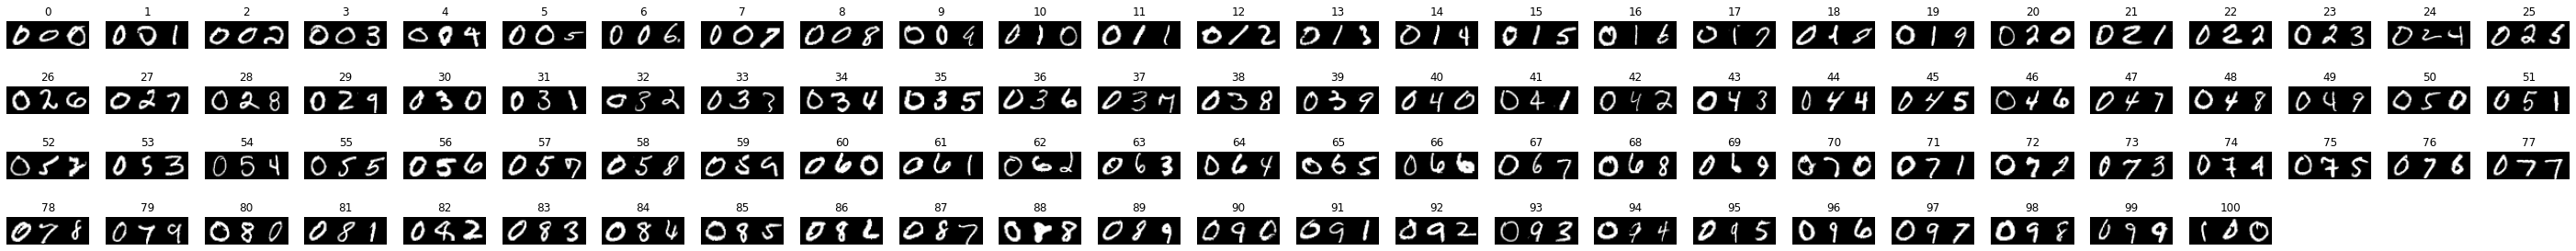

In [0]:
def displayImages(dataset):
  plt.figure(figsize=[50,5])
  for i in range(101):
     image = dataset[i][np.random.randint(len(dataset[i]))]
     plt.subplot(4,26,i+1)
     plt.title(i)
     plt.axis(False)
     plt.imshow(image,cmap='gray')   
  plt.show  

displayImages(dataset)


# **Rotation function**

In [0]:
def getRotationMatrix2D(cx,cy,angle):
    cos = math.cos(math.radians(angle))
    sin = math.sin(math.radians(angle))
    u = (1-cos)*cx-sin*cy #Calculate center x offest to the center 
    v = sin*cx+(1-cos)*cy #Calculate center y offest to the center
    return np.array([[cos,sin,u], [-sin,cos,v]]),cos,sin

def warpAffine(image, matrix):
    dst = np.zeros(image.shape, dtype=np.uint8)
    oldh, oldw = image.shape[:2]
    for u in range(oldh):
        for v in range(oldw):
            x = (u-(dst.shape[0]/2))*matrix[0,0]+(v-(dst.shape[1]/2))*matrix[0,1]+dst.shape[0]/2
            y = (u-(dst.shape[0]/2))*matrix[1,0]+(v-(dst.shape[1]/2))*matrix[1,1]+dst.shape[1]/2
            intx, inty = int(x), int(y)
            if 0 <= intx < oldh and 0 <= inty < oldw:
                pixel = image[intx, inty]
                dst[u, v] = pixel
    return dst    

def rotate_image(image, angle):
    height, width = image.shape[:2]
    image_center = (width / 2, height / 2)
    rotation_mat , cos, sin  = getRotationMatrix2D(image_center[0],image_center[1], angle)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))
    #Update  the new center(u) after the rotate
    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    #Update  the new center(v) after the rotate
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])
    rotated_mat = warpAffine(image, rotation_mat)
    return rotated_mat

# **Augmentation class**

In [0]:
class Augmentation:
  
  def flip(self,img,p,axis = [0,1]):
    if self.proba(p):
      rand = axis[np.random.randint(len(axis))] 
      if rand > 1:
        print("flip error")
        return img
      return np.flip(img,axis=rand) , "Flip"
    else:
      return img ,"" 

  def zoom_in(self,img,p,f = [2,4,6]):
    if self.proba(p):
      index = np.random.randint(len(f))
      factor = f[index]
      shape = img.shape
      factor_rand = int(np.random.random(1) * factor) + 1 
      cropsize_y = int(shape[0]/factor_rand)
      cropsize_x = int(shape[1]/factor_rand)
      offset_x = np.random.randint(cropsize_x)
      offset_y = np.random.randint(cropsize_y)
      new_img = img[offset_y:min(offset_y + cropsize_y,shape[0]),offset_x:min(offset_x + cropsize_x,shape[1])]
      return cv2.resize(new_img,(shape[1],shape[0])) , "Zoom_in"
    else:
      return img ,""  

  def rotate(self,img,p,min_angle = -30,max_angle = 30):
    if self.proba(p):
      rand_angle = np.random.randint(max_angle) + min_angle
      rotated_image  = rotate_image(img,rand_angle)
      return rotated_image , "Rotate"
    else:
      return img ,"" 

  def gaussianBlur(self,img,p,sigma=[3,5,7,9]):
    if self.proba(p):
      index = np.random.randint(len(sigma))
      s = sigma[index]  
      output = cv2.GaussianBlur(img,(s,s),0)
      return output , "Gaussian blur"
    else:
       return img , ""

  def medianBlur(self,img,p,num=[3,5,7,9,11,13,15,17,19,21]):
    if self.proba(p):
      random_kernel = np.random.randint(len(num))
      ksize = num[random_kernel]
      median = cv2.medianBlur(img,ksize)  
      return median , "MedianBlur"
    else: 
      return img , ""

  def crop(self,img,p,factor=2):
    if self.proba(p):
      shape = img.shape
      factor_rand_y = int(np.random.random(1) * factor) + 1
      factor_rand_x = int(np.random.random(1) * factor) + 1
      cropsize_y = int(shape[0] / factor_rand_y)
      cropsize_x = int(shape[1] / factor_rand_x)
      offset_x = np.random.randint(cropsize_x)
      offset_y = np.random.randint(cropsize_y)
      new_img = img[offset_y:min(offset_y + cropsize_y,shape[0]),offset_x:min(offset_x + cropsize_x,shape[1])]
      return new_img , "Crop"
    else:
      return img ,""
      
  #  alpha  : contrast control 1.0-3.0
  #  beta : brightness control 0-100
  def brightness(self,img,p,alpha = [2.0 , 3.0 , 4.0 , 5.0 , 6.0 , 7.0 , 8.0, 9.0],beta = 100):
    if self.proba(p):
      new_image = np.zeros(img.shape, img.dtype)
      index = np.random.randint(len(alpha))
      rand_alpha = alpha[index]
      rand_beta = np.random.randint(beta)
      for y in range(img.shape[0]):
        for x in range(img.shape[1]):
          if len(img.shape) == 3:
            for c in range(img.shape[2]):
              new_image[y,x,c] = np.clip(rand_alpha*img[y,x,c] + rand_beta, 0, 255)
          else: 
              new_image[y,x] = np.clip(rand_alpha*img[y,x] + rand_beta, 0, 255)  
      return new_image , "Brightness"        
    else: 
      return img , ""
  
  def gamma(self,img,p,gamma=[0.2,0.5,0.7,1.2,1.5,1.7,2]):
    if self.proba(p):
      index = np.random.randint(len(gamma))
      g = gamma[index]
      invGamma = 1.0 / g
      table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
      img = np.uint8(img)
      return cv2.LUT(img, table) ,"Gamma" 
    else:
      return img , ""

  def hue_saturation_value(self,img,p,saturation = [50,100,150]):
    if self.proba(p):
      index = np.random.randint(len(saturation))
      s = saturation[index]
      img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
      v = img[:, :, 2]
      v = np.where(v <= 255 - s, v + s, 255)
      img[:, :, 2] = v  
      return cv2.cvtColor(img, cv2.COLOR_HSV2BGR) ," Saturation"
    else:
      return img ,""

  def sobel(self,img,p,ksize=[3,5,7,9] , direction = [(1,0),(1,0)]):
    if self.proba(p):
      num = np.random.random()
      if num < 0.5:
        dx , dy = direction[0]
      else:
        dx , dy = direction[1]  
      index = np.random.randint(len(ksize))
      size_kernel = ksize[index]
      return cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=size_kernel) , "Sobel"
    else:
      return img , ""

  def sobelxy(self,img,p,ksize=[3,5,7,9] , direction = [(1,0),(0,1)]):
    if self.proba(p):
        dx , dy = direction[0]
        index = np.random.randint(len(ksize))
        size_kernel = ksize[index]
        sobelx = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=size_kernel)
        dx , dy = direction[1]  
        sobely = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=size_kernel)
        return cv2.sqrt(cv2.addWeighted(cv2.pow(sobelx, 2.0), 1.0, cv2.pow(sobely,2.0), 1.0, 0.0)) , "Sobel_XY"
    else:
      return img ,""       
    
  def canny_edge_detection(self,img,p,threshold = [(50,150),(100,200)]):
    if self.proba(p):
      if len(img.shape) == 3:
        img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
      index = np.random.randint(len(threshold))
      minVal , maxVal = threshold[index]
      img = np.uint8(img)
      return cv2.Canny(img,minVal,maxVal), "Canny_Edge_Detection"
    else:
      return img , ""

  def grayscale(self,img,p):
    if self.proba(p):
      return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) , "Grayscale"
    else:
      return img ,""

  def salt(self,img,p,percent = [0.05 , 0.1 , 0.15]):
    if self.proba(p):
      index = np.random.randint(len(percent))
      per = percent[index]
      if len(img.shape) == 3:
        rows , cols , channels = img.shape
      else:
        rows , cols = img.shape
      output = np.zeros(img.shape , np.uint8)
      for row in range(rows):
        for col in range(cols):
          rand = np.random.random()
          if rand < per:
            if len(img.shape) == 3:
              output[row,col] = (255,255,255)
            else:
              output[row,col] = 255  
          else:
            output[row,col] = img[row,col]
      return output , "Salt"
    else:
      return img  , ""   

  def pepper(self,img,p,percent = [0.05 , 0.1 , 0.15]):
    if self.proba(p):
      index = np.random.randint(len(percent))
      per = percent[index]
      if len(img.shape) == 3:
        rows , cols , channels = img.shape
      else:
        rows , cols = img.shape
      output = np.zeros(img.shape , np.uint8)
      for row in range(rows):
        for col in range(cols):
          rand = np.random.random()
          if rand < per:
            if len(img.shape) == 3:
                output[row,col] = (0,0,0)
            else:
                output[row,col] = 0    
          else:
              output[row,col] = img[row,col]
      return output , "Pepper"
    else:
      return img , ""

  def salt_pepper(self,img,p,percent = [0.05 , 0.1 , 0.15 , 0.2 , 0.25] ):
    if self.proba(p):
      index = np.random.randint(len(percent))
      per = percent[index]
      if len(img.shape) == 3:
        rows , cols , channels = img.shape
      else:
        rows , cols = img.shape
      output = np.zeros(img.shape , np.uint8)
      for row in range(rows):
        for col in range(cols):
          rand = np.random.random()
          if rand < per/2:
            if len(img.shape) == 3:
              output[row,col] = (0,0,0)
            else:
              output[row,col] = 0  
          elif rand < per:
            if len(img.shape) == 3:
              output[row,col] = (255 , 255 , 255)
            else:
              output[row,col] = 255  
          else:
            output[row,col] = img[row,col]
      return output , "Salt and Pepper"
    else:
      return img , ""

  def invert_image(self,img,p,channel= [50,100,150,200,255]):
     if self.proba(p):
        index = np.random.randint((len(channel)))
        channell = channel[index]
        image=(channell-img)
        return image , "Invert"
     else:
      return img  , ""

  def proba(self,p):
    c = np.random.random(1)
    if c<p:
      return True
    else:
      return False

  def norm(self,image):
    image = image.astype(float)
    image -= image.min()
    image += image.max()
    return image  

## **Operate augmentation class** 

In [0]:
class OperateAugmentation(Augmentation):
  def __init__(self,n = {'flip' : 0.3 ,'rotate': 0.6 ,'salt_pepper': 0.4 , 'brightness': 0.3, 'sobel': 0.6}):
    self.choise = n
    
  def executeAugmentations(self ,image):
        title_aug = []
        img = np.copy(image)
        for key in self.choise.keys():
            if key == 'flip':
              img , title = super().flip(img,self.choise['flip'])
              title_aug.append(title)
            if key == 'zoom_in':
              img , title = super().zoom_in(img,self.choise['zoom_in'])
              title_aug.append(title)
            if key == 'crop':
              img , title = super().crop(img,self.choise['crop'])
              title_aug.append(title)
            if key == 'rotate':
              img , title = super().rotate(img,self.choise['rotate'])
              title_aug.append(title)
            if key == 'gaussianBlur':
              img , title = super().gaussianBlur(img,self.choise['gaussianBlur'])
              title_aug.append(title)
            if key == 'medianBlur':
              img , title =super().medianBlur(img,self.choise['medianBlur'])
              title_aug.append(title)
            if key == 'brightness':
              img , title = super().brightness(img,self.choise['brightness'])
              title_aug.append(title)
            if key == 'gamma':
              img , title = super().gamma(img,self.choise['gamma'])
              title_aug.append(title)
            if key == 'hue_saturation_value':
              img , title = super().hue_saturation_value(img,self.choise['hue_saturation_value'])
              title_aug.append(title)
            if key == 'sobel':
              img , title = super().sobel(img,self.choise['sobel'])
              title_aug.append(title)
            if key == 'canny':
              img , title = super().canny_edge_detection(img,self.choise['canny'])
              title_aug.append(title)
            if key == 'grayscale':
              img , title = super().grayscale(img,self.choise['grayscale'])
              title_aug.append(title)
            if key == 'salt':
              img , title = super().salt(img,self.choise['salt'])
              title_aug.append(title)
            if key == 'pepper':
              img , title = super().pepper(img,self.choise['pepper'])
              title_aug.append(title)
            if key == 'salt_pepper':
              img , title  = super().salt_pepper(img,self.choise['salt_pepper'])
              title_aug.append(title)
            if key == 'invert_image':
              img , title = super().invert_image(img,self.choise['invert_image'])
              title_aug.append(title)
            if key == 'sobelxy':
              img , title = super().sobelxy(img,self.choise['sobelxy'])
              title_aug.append(title)                    
        title = self.titles(title_aug)
        return img ,title
      
  def titles(self,title_list):
    string = ''
    for i in title_list:
      string +=  str(i)  + " "     
    return string     

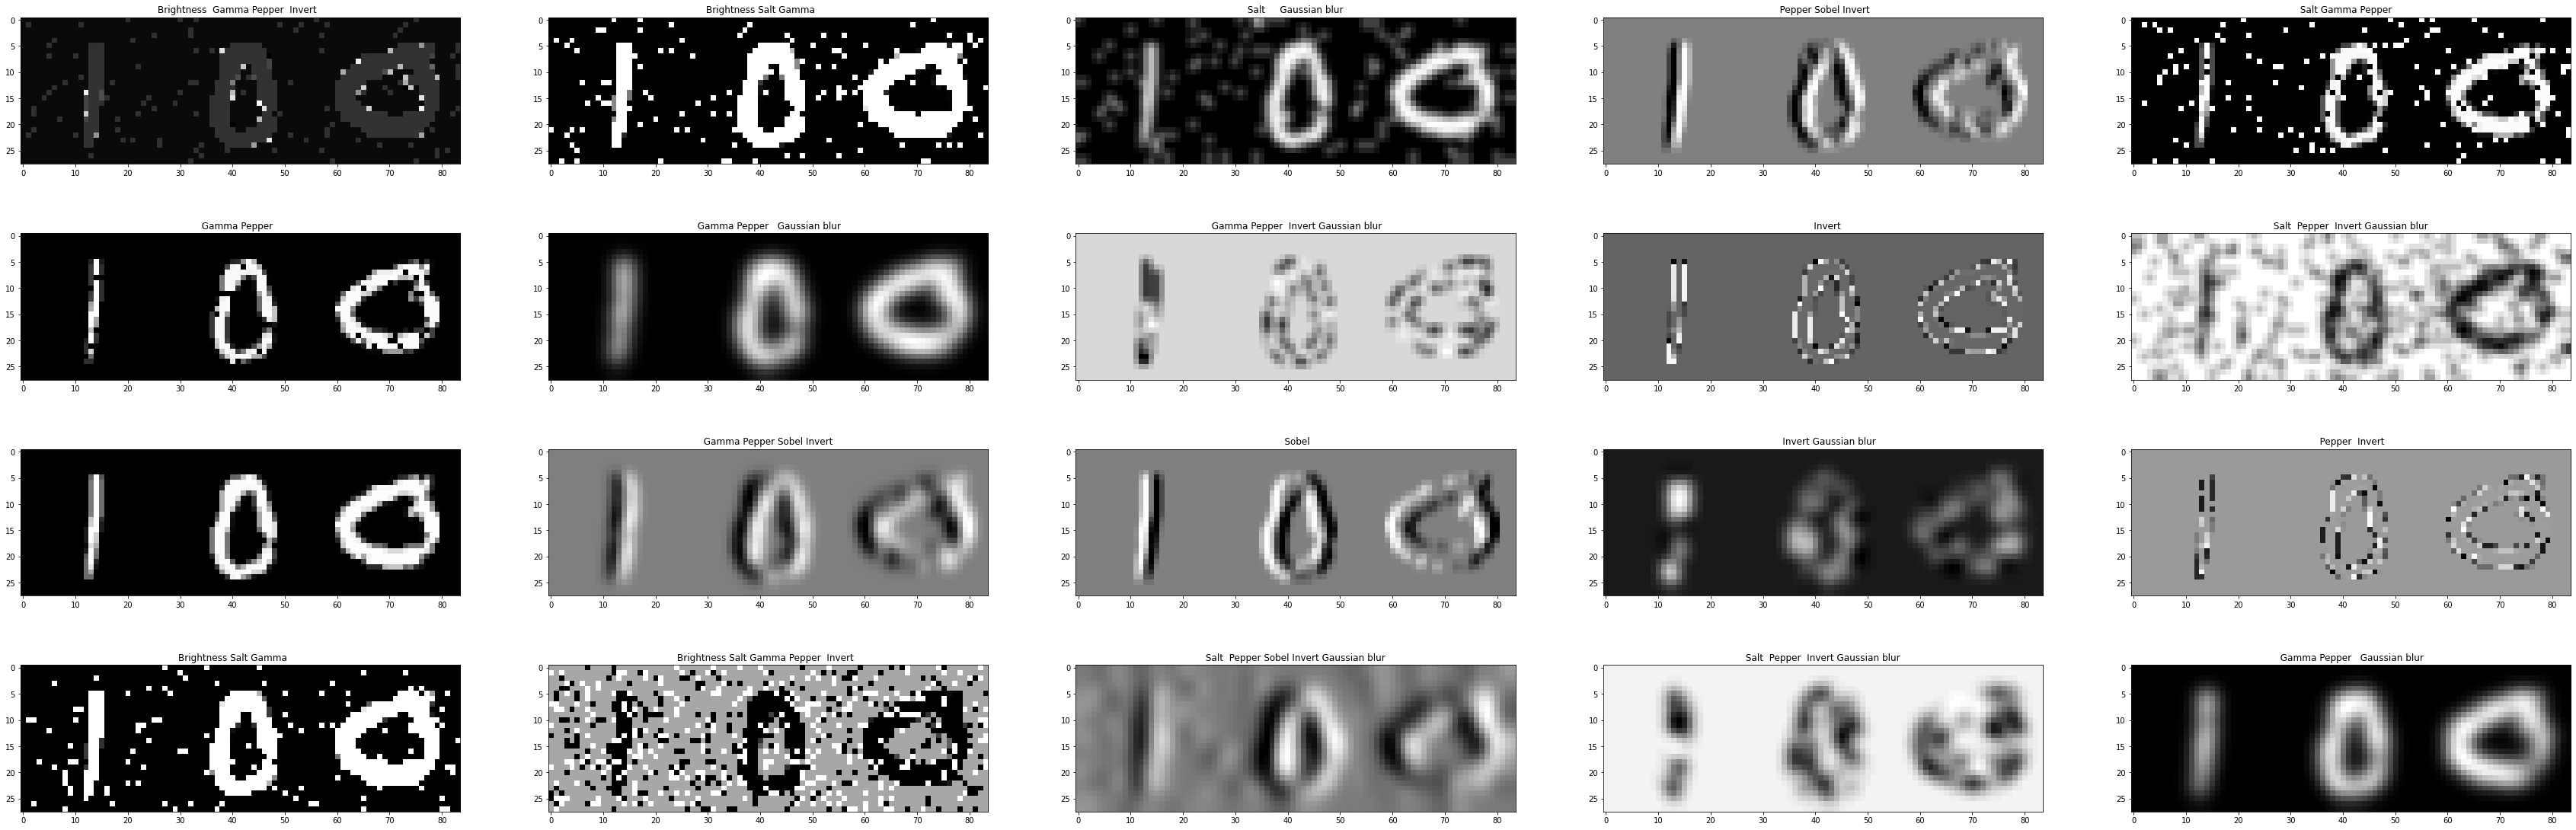

In [0]:
def printImages():
  augmentations = { 'brightness': 0.2  ,'salt' : 0.5 ,'gamma':0.5 , 'pepper' : 0.5 , 'sobel' : 0.5 ,'invert_image':0.5,'gaussianBlur' : 0.5}
  img = dataset[100][0]
  aug = OperateAugmentation(augmentations)
  plt.figure(figsize=[60,20])
  for i in range(20):
    image_aug , title = aug.executeAugmentations(img)
    plt.subplot(4,5,i+1)
    plt.title(title)       
    plt.imshow(image_aug,cmap = 'gray' )  
  plt.show

printImages()

# **Contours**

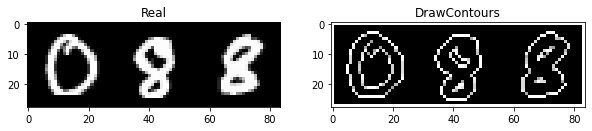

In [0]:
def findContours(img):
  ret,thresh = cv2.threshold(img,100,150,1)
  img_draw = np.copy(img)
  contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
  image = cv2.drawContours(img_draw,contours,-1,(255,255,255),1)
  contour = abs(image - img)
  plt.figure(figsize=[10,10])
  plt.subplot(121)
  plt.imshow(img, cmap= 'gray')
  plt.title('Real')
  plt.subplot(122)
  plt.imshow(contour,cmap = 'gray')
  plt.title('DrawContours')
  plt.show()

img = dataset[88][2]
findContours(img)



## **Part - 2**

In [0]:
class Shapes():
  
  @classmethod
  def lengthSquare(self,X, Y):  
    xDiff = X[0] - Y[0]  
    yDiff = X[1] - Y[1]  
    return xDiff * xDiff + yDiff * yDiff 
  
  @classmethod
  def triangleRule(self,a , b, c):
    if a + b > c and a + c > b and b + c > a:
      return True
    else:
      return False

  def createTriangle(image):
    img = np.zeros(image.shape,dtype=np.uint8)
    x0,x1,x2 = np.random.choice(image.shape[0], 3 )[:3]
    y0,y1,y2 = np.random.choice(image.shape[1], 3 )[:3]

  #Calculate area grather than 25 
    while (x0*y1 + x1*y2 + x2*y0 - x0*y2 - x1*y0 - x2*y1) / 2 < abs(25):
      x0,x1,x2 = np.random.choice(image.shape[0], 3 )[:3]
      y0,y1,y2 = np.random.choice(image.shape[1], 3 )[:3]

    A = np.array([x0 , y0])
    B = np.array([x1 , y1])
    C = np.array([x2 , y2])
    a2 = Shapes.lengthSquare(B, C)  
    b2 = Shapes.lengthSquare(A, C)  
    c2 = Shapes.lengthSquare(A, B)   
    a = math.sqrt(a2)  
    b = math.sqrt(b2) 
    c = math.sqrt(c2)

    while not Shapes.triangleRule(a , b, c): 
      x2 = np.random.choice(10,1)
      y2 = np.random.choice(10,1)
      C = np.array([x2 , y2])
      a2 = Shapes.lengthSquare(B, C)  
      b2 = Shapes.lengthSquare(A, C)  
      c2 = Shapes.lengthSquare(A, B) 
      a = math.sqrt(a2)  
      b = math.sqrt(b2) 
      c = math.sqrt(c2)

    points = np.array([A,B,C],dtype = np.int32)
    r = np.random.randint(255)
    g = np.random.randint(255)
    b = np.random.randint(255)
    cv2.polylines(img,[points] , True , (r,g,b),1)
    cv2.drawContours(img, [points], 0, (r,g,b),-1)
    return img

  def createRectangle(image):

    img = np.ones(image.shape,dtype=np.uint8)
    w = np.random.randint(image.shape[0]) + 1
    h = np.random.randint(image.shape[1]) + 1
    x = np.random.randint(image.shape[0]) + 1
    y = np.random.randint(image.shape[1])+ 1
    r = np.random.randint(255) + 2
    g = np.random.randint(255) + 2
    b = np.random.randint(255) + 2
  
    while x + w >= image.shape[0]:
      w = np.random.randint(image.shape[0])
      x = np.random.randint(image.shape[0])
    while y + h >= image.shape[1]:
      h = np.random.randint(image.shape[1])
      y = np.random.randint(image.shape[1])

    for row in range(x , x + w):
      img[y , row] = (r,g,b)
    for col in range(y , y + h):
      img[col , x] = (r,g,b)
    for col in range(y + h ,y - 1, -1):
      img[col , x + w] = (r,g,b) 
    for row in range(x + w ,x - 1, -1):
      img[y + h, row] = (r,g,b)  
    points = np.array([[x,y],[x,y+h],[x+w,y+h],[x+w,y]],dtype = np.int32)
    cv2.drawContours(img, [points], 0, (r,g,b),-1)  
    return img


  def createEllipse(image):

    r = np.random.randint(255) + 15
    g = np.random.randint(255) + 15
    b = np.random.randint(255) + 15

    # set up a coordinate system
    v = np.random.randint(30)  + 15
    u = np.random.randint(30)  + 15 
  
    x = np.linspace(-v, v, image.shape[0])
    y = np.linspace(-u, u, image.shape[1])
 
    # Setup arrays which just list the x and y coordinates
    xgrid, ygrid = np.meshgrid(x, y)

    a = np.random.randint(15) + 3
    b = np.random.randint(15) + 4

    # Calculate the ellipse values all at once
    center_x = np.random.randint(8)
    center_y = np.random.randint(15)
    ellipse = (xgrid - center_x)**2 / a**2 + (ygrid -center_y)**2 / b**2

    if image.shape[2]  > 0:
      # Create an array of uint8 zeros
      img = np.zeros(image.shape, dtype=np.uint8)
      img[ellipse < 1.0] = (r,g,b)
    else:
      img = np.zeros(image.shape) 
      img[ellipse < 1.0] = 255
    return img


In [0]:
 class CreateDataShapes():   
    def __init__(self,numberOfImages):
     self.data = {}
     self.data["Rectangle"] = []
     self.data["Triangle"] = []
     self.data["Circle"] = []
     self.numberOfImages = numberOfImages
     for i in range(0,numberOfImages):
       self.data["Rectangle"].append(Shapes.createRectangle(np.zeros((50,50,3))))
       self.data["Triangle"].append(Shapes.createTriangle(np.zeros((50,50,3))))
       self.data["Circle"].append(Shapes.createEllipse(np.zeros((50,50,3))))       

    def augs(image):
      augmentations = {'rotate':0.4, 'gaussianBlur': 0.4 ,'pepper': 0.3, 'salt': 0.3 ,'brightness': 0.2 , 'invert_image':0.5 , 'hue_saturation_value' : 0.4 }
      aug = OperateAugmentation(augmentations)         
      return aug.executeAugmentations(image)  

    def load_data(self):
      x_train = []
      y_train = []
      x_test = []
      y_test = []
      train = 2/3  # 1-(train) for test 
      for i in range(0,int(self.numberOfImages*train)):
        x_train.append(self.data["Rectangle"][i])
        y_train.append("Rectangle")
        rectangle , title  = CreateDataShapes.augs(self.data["Rectangle"][i])
        x_train.append(rectangle)
        y_train.append("Rectangle")
        x_train.append(self.data["Triangle"][i])
        y_train.append("Triangle")
        triangle , title = CreateDataShapes.augs(self.data["Triangle"][i])
        x_train.append(triangle)
        y_train.append("Triangle")
        x_train.append(self.data["Circle"][i])
        y_train.append("Circle")
        circle , title = CreateDataShapes.augs(self.data["Circle"][i])
        x_train.append(circle)
        y_train.append("Circle")
      for i in range(int(self.numberOfImages*train),self.numberOfImages):
        rectangle , title  = CreateDataShapes.augs(self.data["Rectangle"][i])
        x_test.append(rectangle)
        y_test.append("Rectangle")
        triangle , title = CreateDataShapes.augs(self.data["Triangle"][i])
        x_test.append(triangle)
        y_test.append("Triangle")
        circle , title = CreateDataShapes.augs(self.data["Circle"][i])
        x_test.append(circle)
        y_test.append("Circle")
      return (x_train,y_train),(x_test,y_test)

data = CreateDataShapes(300)
(x_train, y_train), (x_test, y_test) = data.load_data()
      

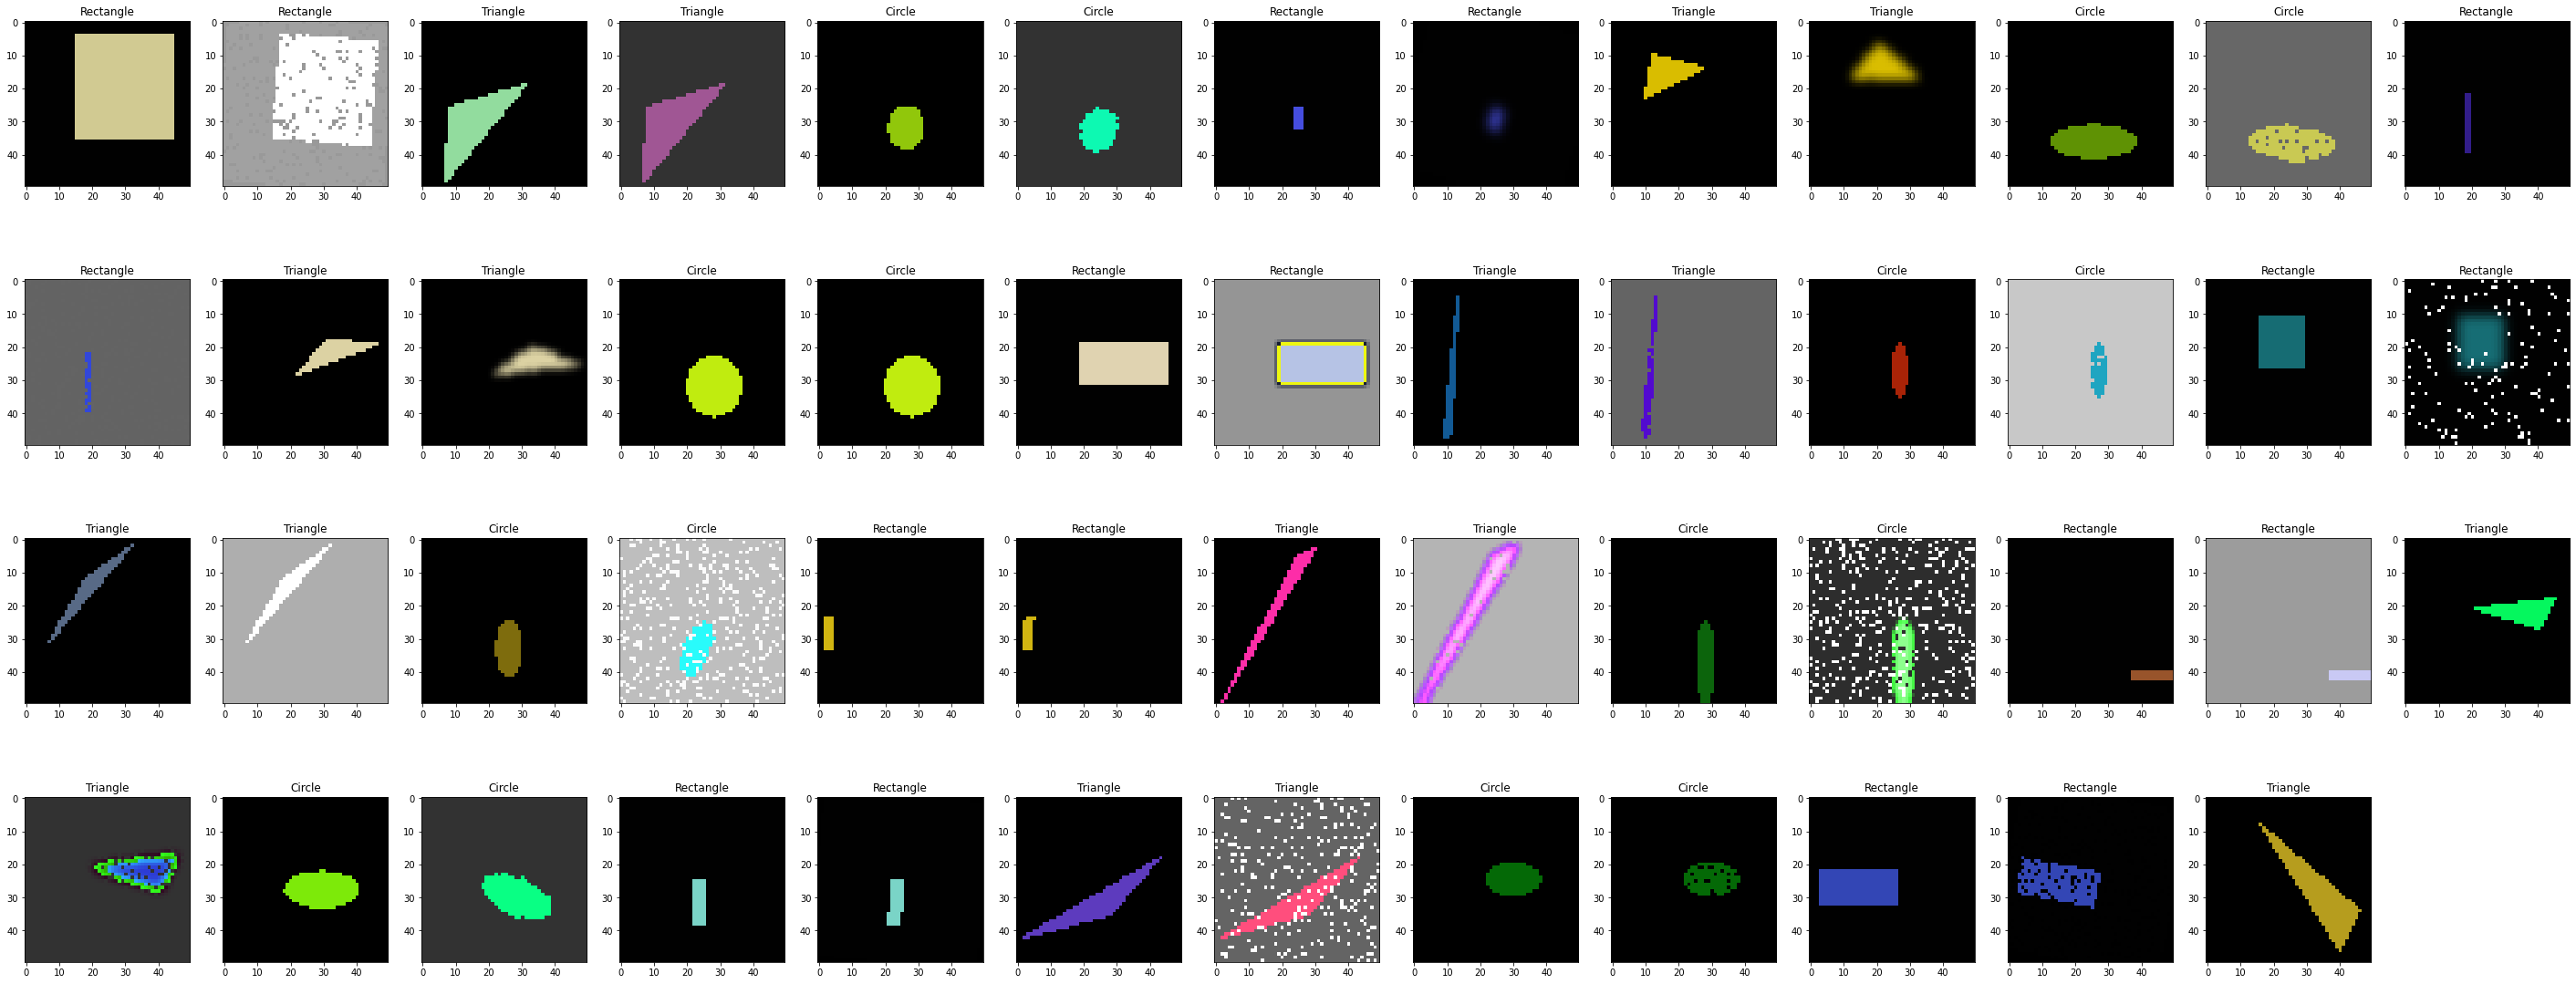

In [0]:
plt.figure(figsize=[50, 20])
for i in range(0,51):
  plt.subplot(4,13,i+1)
  plt.title(y_train[i])
  plt.imshow(x_train[i].astype(np.uint8)) 

**Shapes** - This class produces the shapes randomly according to the resolution of the image.

**CreateDataShapes** -  A class that creates a database of shapes.


